## 💽 Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ⬇️ Data Download

In [1]:
!wget --no-check-certificate https://www.crcv.ucf.edu/data/ucf_sports_actions.zip

--2022-05-26 20:27:02--  https://www.crcv.ucf.edu/data/ucf_sports_actions.zip
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1777599139 (1.7G) [application/zip]
Saving to: ‘ucf_sports_actions.zip’

ucf_sports_actions. 100%[===================>]   1.66G  12.7MB/s    in 2m 12s  

2022-05-26 20:29:14 (12.9 MB/s) - ‘ucf_sports_actions.zip’ saved [1777599139/1777599139]



In [2]:
!unzip /content/ucf_sports_actions.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: ucf_sports_actions/ucf action/Walk-Front/005/RF1-11529_70095.jpg  
  inflating: ucf_sports_actions/ucf action/Walk-Front/005/RF1-11529_70096.jpg  
  inflating: ucf_sports_actions/ucf action/Walk-Front/005/RF1-11529_70097.jpg  
  inflating: ucf_sports_actions/ucf action/Walk-Front/005/RF1-11529_70098.jpg  
  inflating: ucf_sports_actions/ucf action/Walk-Front/005/RF1-11529_70099.jpg  
  inflating: ucf_sports_actions/ucf action/Walk-Front/005/RF1-11529_70100.jpg  
  inflating: ucf_sports_actions/ucf action/Walk-Front/005/Thumbs.db  
   creating: ucf_sports_actions/ucf action/Walk-Front/006/
   creating: ucf_sports_actions/ucf action/Walk-Front/006/gt/
 extracting: ucf_sports_actions/ucf action/Walk-Front/006/gt/RF1-13902_70016.tif.txt  
 extracting: ucf_sports_actions/ucf action/Walk-Front/006/gt/RF1-13902_70017.tif.txt  
 extracting: ucf_sports_actions/ucf action/Walk-Front/006/gt/RF1-13902_70018.tif.txt  
 extracting: ucf_spor

## 📥 > 📙 Import to Libraries

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import Sequential
import tensorflow as tf

## 📋 Data Preparing

In [4]:
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=False,
    featurewise_std_normalization=True,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1.0/255.0,
    preprocessing_function=None,
    data_format=None,
    dtype=None,
    validation_split=0.26)
train_generator = train_datagen.flow_from_directory("/content/ucf_sports_actions/ucf action",target_size=(96, 96),
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    interpolation="nearest",
                                                    subset="training")
test_generator = train_datagen.flow_from_directory("/content/ucf_sports_actions/ucf action",target_size=(96, 96),
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    interpolation="nearest",
                                                    subset="validation")

Found 12783 images belonging to 13 classes.
Found 4487 images belonging to 13 classes.


## 🧱 Models Structure and Code [Function]

In [5]:
def func(pre,name_model):
    print('#####~Model => {} '.format(name_model))
    pre_model = name_model(input_shape=(96,96, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(13, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')]
    
    history = model.fit(train_generator,validation_data=test_generator,epochs=50,callbacks=my_callbacks,verbose=0)
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
    plt.show()
    
    # Predict Data Test
    pred = model.predict(test_generator)
    pred = np.argmax(pred,axis=1)
    labels = (train_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    print('\033[01m              Classification_report \033[0m')
    
    print('\033[01m              Results \033[0m')
    # Results
    results = model.evaluate(test_generator, verbose=0)
    print("    Test Loss:\033[31m \033[01m {:.5f} \033[30m \033[0m".format(results[0]))
    print("Test Accuracy:\033[32m \033[01m {:.2f}% \033[30m \033[0m".format(results[1] * 100))
    
    return results

In [24]:
def emir_model():
  inp = Input(shape = (96,96,3))

  x = Conv2D(64, (3,3), strides=(2,2), padding='same', activation='tanh', use_bias=True)(inp)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), strides=(2,2), padding='same', activation='tanh', use_bias=True)(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same', data_format=None)(x)
  x = Conv2D(128, (3,3), strides=(2,2), padding='same', activation='tanh', use_bias=True)(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3,3), strides=(2,2), padding='same', activation='tanh', use_bias=True)(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same', data_format=None)(x)
  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  x = Dense(64, activation='relu')(x)
  x = Dense(13, activation='softmax')(x)

  model = Model(inputs=inp, outputs= x)
  return model

In [27]:
def emirhan_func(name_model):

    print('#####~Model => {} '.format(name_model))

    model = emir_model()
    model.summary()

    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')]
    
    history = model.fit(train_generator,
                        validation_data=test_generator,
                        epochs=20,
                        verbose=1,
                        batch_size=128,)
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
    plt.show()
    
    # Predict Data Test
    pred = model.predict(test_generator)
    pred = np.argmax(pred,axis=1)
    labels = (train_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    print('\033[01m              Classification_report \033[0m')
    
    print('\033[01m              Results \033[0m')
    # Results
    results = model.evaluate(test_generator, verbose=0)
    print("    Test Loss:\033[31m \033[01m {:.5f} \033[30m \033[0m".format(results[0]))
    print("Test Accuracy:\033[32m \033[01m {:.2f}% \033[30m \033[0m".format(results[1] * 100))
    
    return results

## 🏃‍♂️ Prep Models and My Model Benchmark Scores

### VGG19

#####~Model => <function VGG19 at 0x7fc9e7f55170> 
80150528/80134624 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


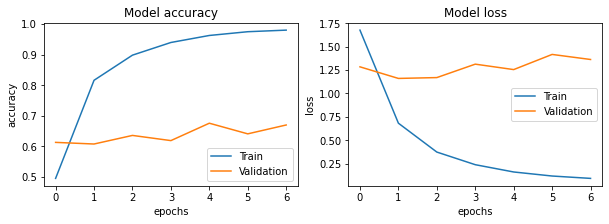

              Classification_report 
              Results 
    Test Loss:  1.36173  
Test Accuracy:  66.99%  


In [8]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
result_VGG19 = func(preprocess_input,VGG19)

### VGG16

#####~Model => <function VGG16 at 0x7fc9e7f4ec20> 
58900480/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


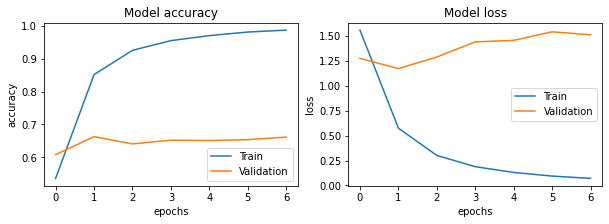

              Classification_report 
              Results 
    Test Loss:  1.50980  
Test Accuracy:  66.12%  


In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
result_VGG16 = func(preprocess_input,VGG16)

### ResNet50

#####~Model => <function ResNet50 at 0x7fc9e7f4acb0> 
94781440/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


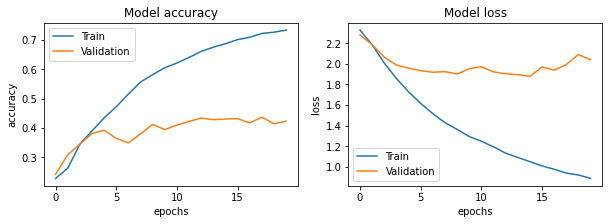

              Classification_report 
              Results 
    Test Loss:  2.03939  
Test Accuracy:  42.32%  


In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
result_ResNet50 = func(preprocess_input,ResNet50)

### ResNet101

#####~Model => <function ResNet101 at 0x7fc9e7f4ad40> 
171458560/171446536 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


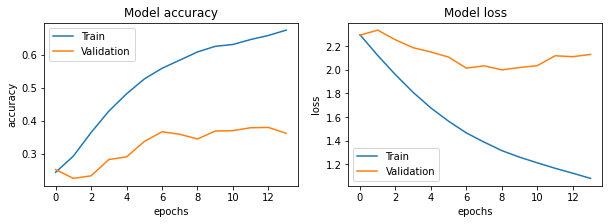

              Classification_report 
              Results 
    Test Loss:  2.13118  
Test Accuracy:  36.19%  


In [11]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input
result_ResNet101 = func(preprocess_input,ResNet101)

### MobileNet

#####~Model => <function MobileNet at 0x7fc9e7fadb00> 
17235968/17225924 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


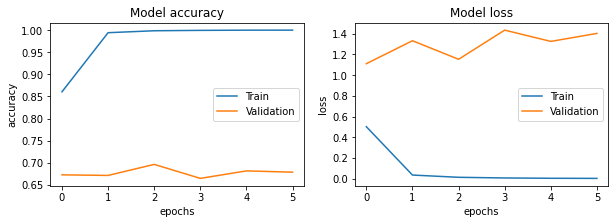

              Classification_report 
              Results 
    Test Loss:  1.40325  
Test Accuracy:  67.88%  


In [12]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
result_MobileNet = func(preprocess_input,MobileNet)

### DenseNet201

#####~Model => <function DenseNet201 at 0x7fc9e7f91a70> 
74850304/74836368 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


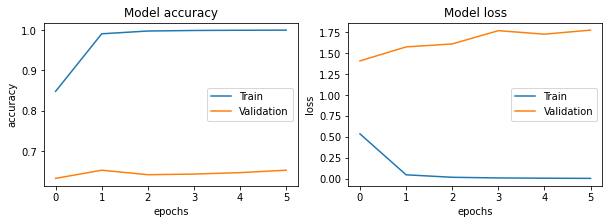

              Classification_report 
              Results 
    Test Loss:  1.77822  
Test Accuracy:  65.26%  


In [13]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
result_DenseNet201 = func(preprocess_input,DenseNet201)

### EfficientNetB7

#####~Model => <function EfficientNetB7 at 0x7fc9e7f94c20> 
258088960/258076736 [==============================] - 3s 0us/step


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


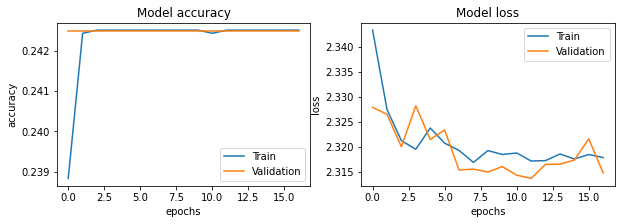

              Classification_report 
              Results 
    Test Loss:  2.31481  
Test Accuracy:  24.25%  


In [14]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
result_Eff = func(preprocess_input,EfficientNetB7)

### Xception

#####~Model => <function Xception at 0x7fc9e7f55680> 
83697664/83683744 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


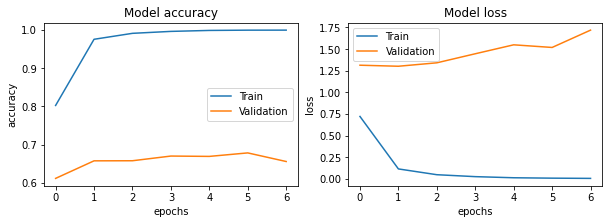

              Classification_report 
              Results 
    Test Loss:  1.71851  
Test Accuracy:  65.59%  


In [15]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
result_Xception = func(preprocess_input,Xception)

### InceptionResNetV2

#####~Model => <function InceptionResNetV2 at 0x7fc9e7fa87a0> 
219070464/219055592 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


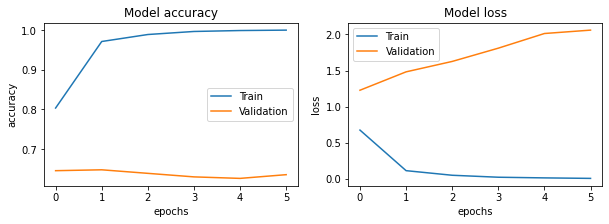

              Classification_report 
              Results 
    Test Loss:  2.06019  
Test Accuracy:  63.58%  


In [16]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
result_InResNetV2 = func(preprocess_input,InceptionResNetV2)

### Model Emirhan

#####~Model => Emirhan_Sports_Actions_Detection_with_Artificial_Intelligence 
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_215 (Conv2D)         (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_215 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_216 (Conv2D)         (None, 24, 24, 64)        36928     
                                                                 
 batch_normalization_216 (Ba  (None, 24, 24, 64)       256       
 tchNormalization)                                               
                                              

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
100/100 [==============================] - 74s 727ms/step - loss: 0.4383 - accuracy: 0.8774 - val_loss: 3.9049 - val_accuracy: 0.1310
Epoch 2/20
100/100 [==============================] - 71s 712ms/step - loss: 0.0268 - accuracy: 0.9966 - val_loss: 4.7090 - val_accuracy: 0.1756
Epoch 3/20
100/100 [==============================] - 71s 708ms/step - loss: 0.0070 - accuracy: 0.9993 - val_loss: 4.2196 - val_accuracy: 0.3042
Epoch 4/20
100/100 [==============================] - 70s 704ms/step - loss: 0.0235 - accuracy: 0.9945 - val_loss: 3.8670 - val_accuracy: 0.3457
Epoch 5/20
100/100 [==============================] - 70s 706ms/step - loss: 0.0085 - accuracy: 0.9986 - val_loss: 3.7377 - val_accuracy: 0.4551
Epoch 6/20
100/100 [==============================] - 71s 708ms/step - loss: 9.8465e-04 - accuracy: 0.9999 - val_loss: 3.5833 - val_accuracy: 0.4887
Epoch 7/20
100/100 [==============================] - 70s 704ms/step - loss: 4.0329e-04 - accuracy: 1.0000 - val_loss: 3.6139 

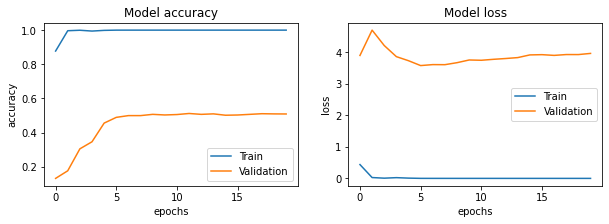

              Classification_report 
              Results 
    Test Loss:  3.96961  
Test Accuracy:  50.86%  


In [28]:
model_name = "Emirhan_Sports_Actions_Detection_with_Artificial_Intelligence"
result_emirhan = emirhan_func(model_name)

## 📊 Finally Result of Table (DataFrame - Pandas)

In [29]:
accuracy_result_table = pd.DataFrame({'Model':['Emirhan_Model','VGG16','VGG19','ResNet50','ResNet101','MobileNet','InceptionResNetV2',
                               'DenseNet201','Xception','EfficientNetB7'],
                      'Accuracy':[result_emirhan[1],result_VGG16[1], result_VGG19[1], result_ResNet50[1], result_ResNet101[1],
                                  result_MobileNet[1],result_InResNetV2[1],result_DenseNet201[1],result_Xception[1],
                                 result_Eff[1]]})

In [30]:
accuracy_result_table

,Model,Accuracy
0,Emirhan_Model,0.508580
1,VGG16,0.661244
2,VGG19,0.669935
3,ResNet50,0.423223
4,ResNet101,0.361934
5,MobileNet,0.678850
6,InceptionResNetV2,0.635837
7,DenseNet201,0.652552
8,Xception,0.655895
9,EfficientNetB7,0.242478


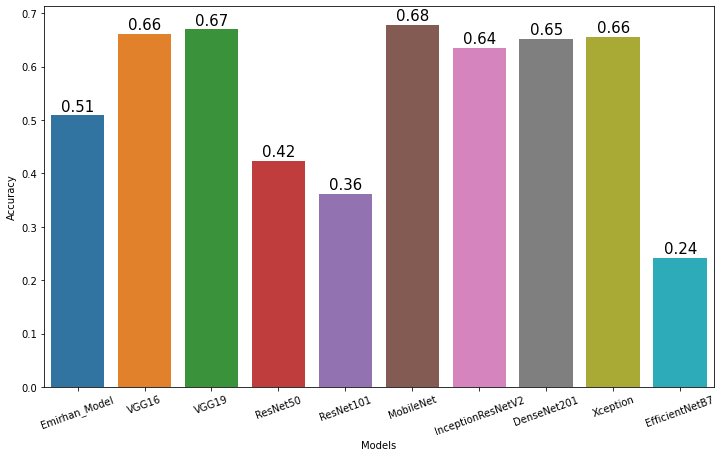

In [31]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=accuracy_result_table)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 9),
                   textcoords='offset points')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=20);

In [32]:
loss_result_table = pd.DataFrame({'Model':['Emirhan_Model','VGG16','VGG19','ResNet50','ResNet101','MobileNet','InceptionResNetV2',
                               'DenseNet201','Xception','EfficientNetB7'],
                      'Loss':[result_emirhan[0],result_VGG16[0], result_VGG19[0], result_ResNet50[0], result_ResNet101[0],
                                  result_MobileNet[0],result_InResNetV2[0],result_DenseNet201[0],result_Xception[0],
                                 result_Eff[0]]})

In [33]:
loss_result_table

,Model,Loss
0,Emirhan_Model,3.969611
1,VGG16,1.509800
2,VGG19,1.361728
3,ResNet50,2.039393
4,ResNet101,2.131178
5,MobileNet,1.403253
6,InceptionResNetV2,2.060190
7,DenseNet201,1.778221
8,Xception,1.718511
9,EfficientNetB7,2.314809


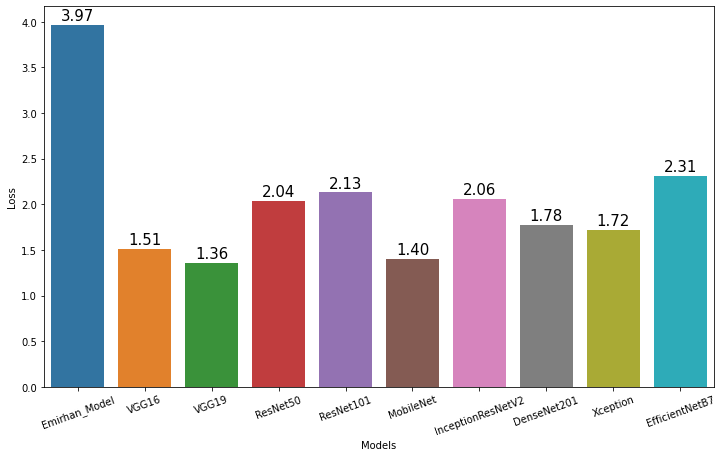

In [34]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Loss', data=loss_result_table)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 9),
                   textcoords='offset points')

plt.xlabel("Models")
plt.ylabel("Loss")
plt.xticks(rotation=20);